In [1]:
%load_ext autoreload
%autoreload 2

from get_data import get_demos

demos = get_demos()


In [2]:
# import matplotlib.pyplot as plt

# plt.imshow(dataset[2][0].cpu().permute(1, 2, 0).numpy(), origin="lower")
# plt.show()

import quaternions

# Convert gripper matrix to quaternion
# These should be the same.
print(quaternions.rotation_matrix_to_quaternion(demos[0][0].gripper_matrix), demos[0][0].gripper_pose[3:])


[-1.09108115e-06  9.92670188e-01 -3.56293425e-06  1.20854867e-01] [-1.09108123e-06  9.92670238e-01 -3.56293435e-06  1.20854869e-01]


In [3]:
# Visualize direction of gripper on camera images
import demo_to_state_action_pairs
from voxel_renderer_slow import VoxelRenderer, SCENE_BOUNDS
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
renderer = VoxelRenderer(SCENE_BOUNDS, 224, torch.tensor([0, 0, 0], device=device), device=device)


[[-9.70788360e-01 -1.30497165e-06  2.39938065e-01]
 [-3.02736362e-06  1.00000000e+00 -6.80991297e-06]
 [-2.39938065e-01 -7.33736260e-06 -9.70788360e-01]]
[[ 0.99803334 -0.00138653 -0.06267005]
 [-0.06267169 -0.0011735  -0.99803358]
 [ 0.00131026  0.99999839 -0.00125813]]
[[ 0.00125805 -0.99803351 -0.06267005]
 [ 0.99999835  0.00117347  0.00138652]
 [-0.00131026 -0.06267169  0.99803334]]
[68, 83, 122]


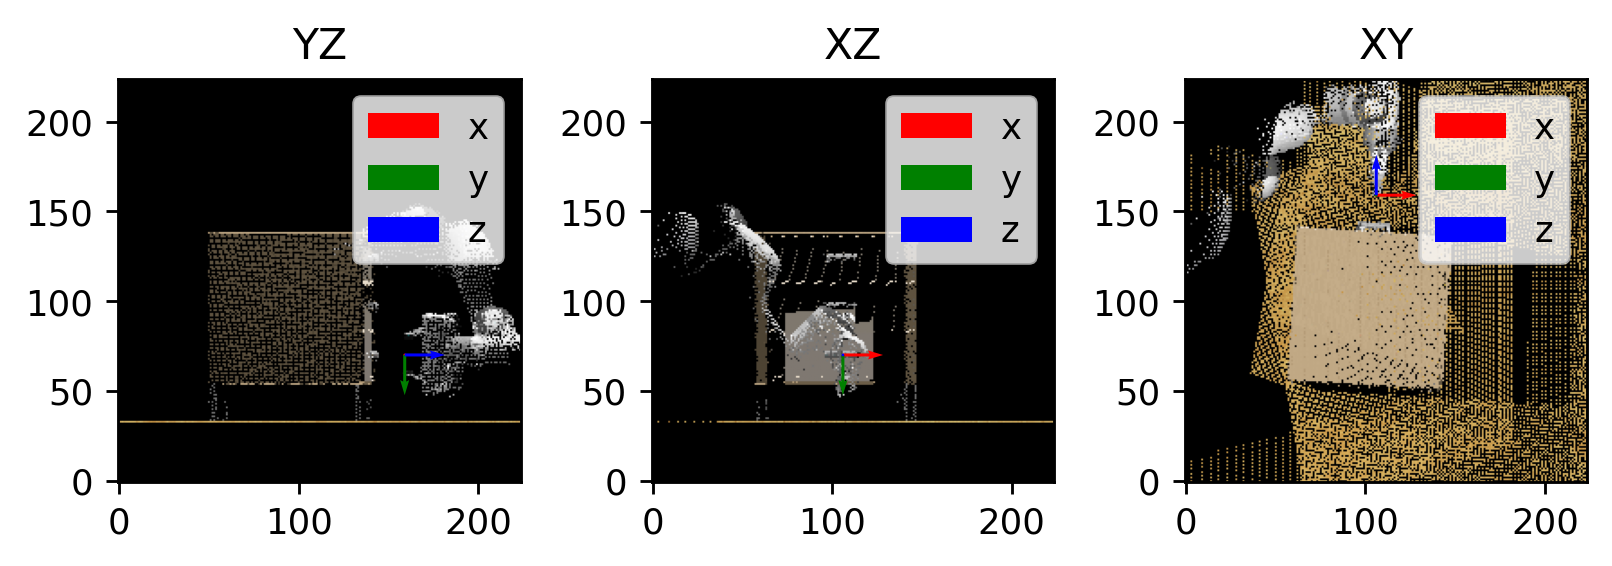

In [26]:
import matplotlib.pyplot as plt

demo = demos[0]

print(demo[0].gripper_matrix[:3, :3])
print(demo[68].gripper_matrix[:3, :3])
print(quaternions.quaternion_to_rotation_matrix(demo[68].gripper_pose[3:]))

labels = demo_to_state_action_pairs.create_orthographic_labels_v2(demo, renderer)

((yz_image, xz_image, xy_image), (yz_pos, xz_pos, xy_pos), (yz_quat, xz_quat, xy_quat)) = labels[0]
(yz_image, xz_image, xy_image) = labels[1][0]

def show_image_with_eef(image, pos, quat):
    plt.imshow(image.cpu().numpy(), origin="lower")

    # Render target gripper rotation
    quat_as_matrix = quaternions.quaternion_to_rotation_matrix(quat)

    # plot x, y, z axes of this matrix
    rotation_matrix_x, rotation_matrix_y, rotation_matrix_z = quat_as_matrix

    # print(rotation_matrix_x[:2])
    # print(rotation_matrix_y[:2])
    # print(rotation_matrix_z[:2])

    arrow_scale = 10
    plt.quiver(pos[0], pos[1], rotation_matrix_x[0], rotation_matrix_x[1], scale=arrow_scale, color='r', label='x')
    plt.quiver(pos[0], pos[1], rotation_matrix_y[0], rotation_matrix_y[1], scale=arrow_scale, color='g', label='y')
    plt.quiver(pos[0], pos[1], rotation_matrix_z[0], rotation_matrix_z[1], scale=arrow_scale, color='b', label='z')

    plt.legend()
    # plt.show()

### YZ IMAGE ###
plt.subplot(1, 3, 1)
plt.title("YZ")
show_image_with_eef(yz_image, yz_pos, yz_quat)
# print(quaternions.quaternion_to_rotation_matrix(quaternions.ROTATE_CAMERA_QUATERNION_TO_WORLD_QUATERNION['yz']))
# print((quaternions.ROTATE_PERSPECTIVE_QUATERNION_TO_WORLD_QUATERNION['yz']))

### XZ IMAGE ###
plt.subplot(1, 3, 2)
plt.title("XZ")
show_image_with_eef(xz_image, xz_pos, xz_quat)
# print(quaternions.quaternion_to_rotation_matrix(quaternions.ROTATE_CAMERA_QUATERNION_TO_WORLD_QUATERNION['xz']))
# print((quaternions.ROTATE_PERSPECTIVE_QUATERNION_TO_WORLD_QUATERNION['xz']))

### XY IMAGE ###
plt.subplot(1, 3, 3)
plt.title("XY")
show_image_with_eef(xy_image, xy_pos, xy_quat)
# print(quaternions.quaternion_to_rotation_matrix(quaternions.ROTATE_CAMERA_QUATERNION_TO_WORLD_QUATERNION['xy']))
# print(quaternions.quaternion_to_rotation_matrix(xy_quat))
# print((quaternions.ROTATE_PERSPECTIVE_QUATERNION_TO_WORLD_QUATERNION['xy']))

plt.tight_layout()
plt.rcParams['figure.dpi'] = 256
plt.show()


x: 0.000 -1.000
y: 1.000 0.000
z: -0.000 1.000
x: -0.000 1.000
y: -1.000 0.000
z: 0.000 1.000
x: 0.215 0.977
y: -0.987 0.158
z: 0.067 0.998
x: -0.215 0.977
y: -0.987 -0.158
z: -0.067 0.998


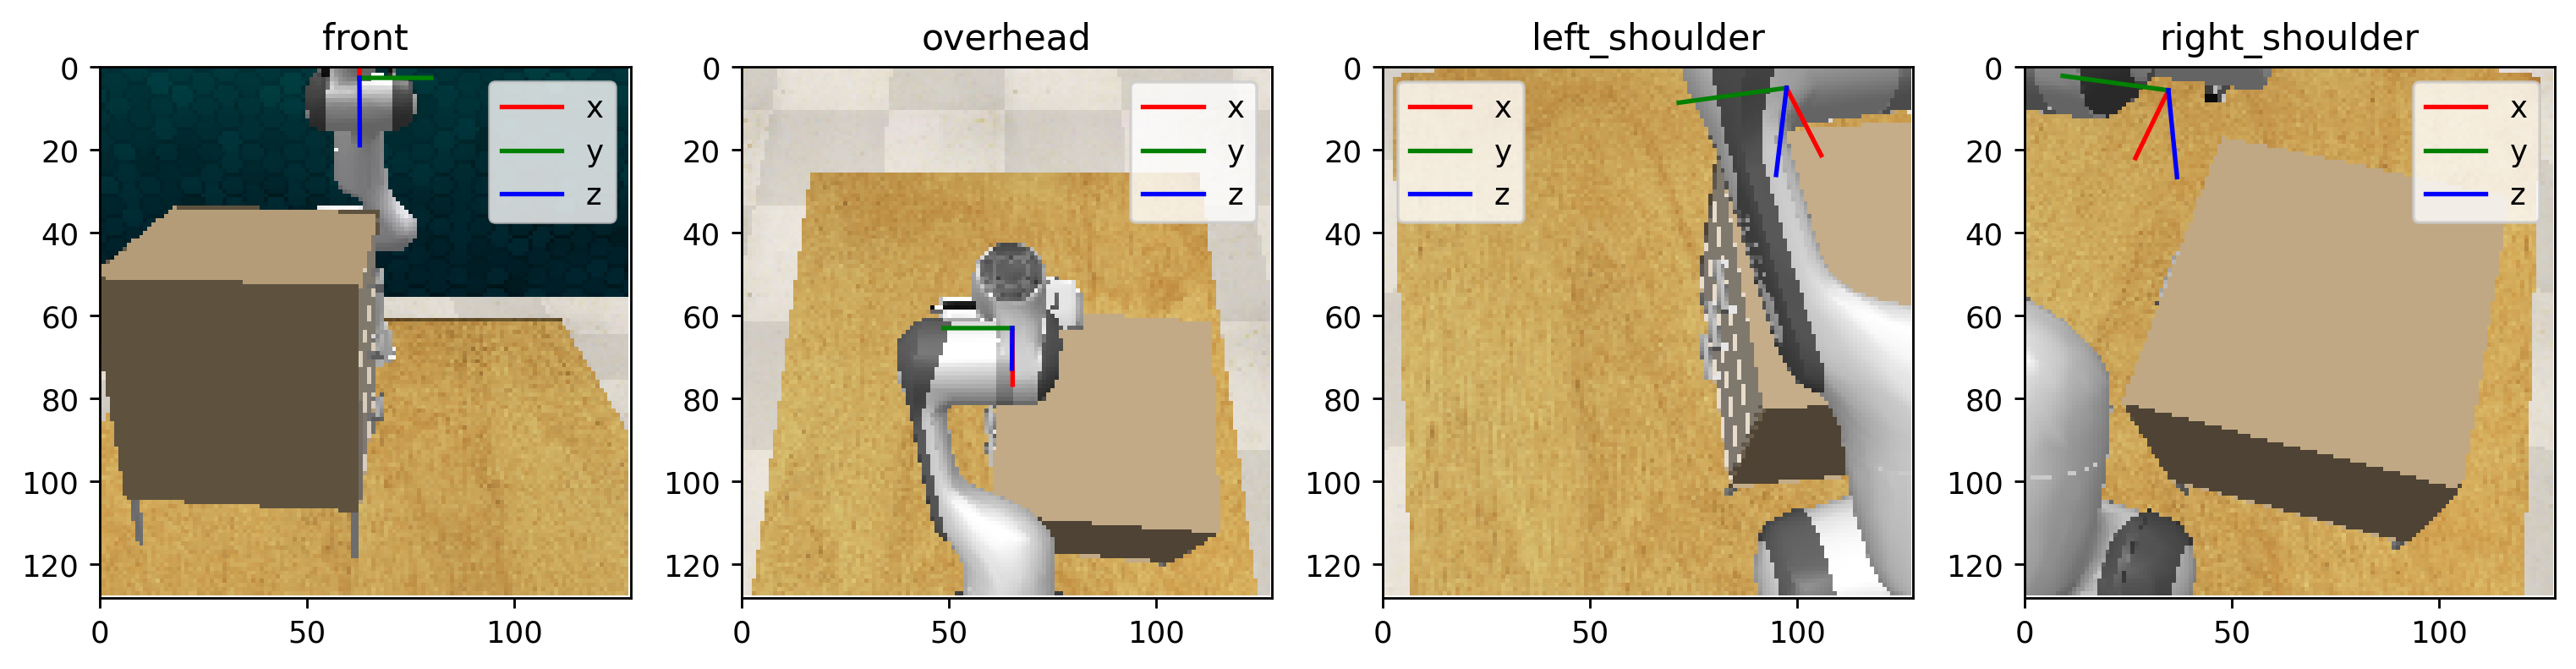

In [131]:
import numpy as np

obs = demos[7][0]

cameras = [
    'front',
    'overhead',
    'left_shoulder',
    'right_shoulder',
]

images = [getattr(obs, camera + '_rgb') for camera in cameras]
extrinsics = [obs.misc[camera + '_camera_extrinsics'] for camera in cameras]
intrinsics = [obs.misc[camera + '_camera_intrinsics'] for camera in cameras]

translation = obs.gripper_matrix[:3, 3]
rotation_matrix = obs.gripper_matrix[:3, :3]

# Render gripper pose.
axis_length = 0.1
x_axis_end = translation + rotation_matrix[0] * axis_length
y_axis_end = translation + rotation_matrix[1] * axis_length
z_axis_end = translation + rotation_matrix[2] * axis_length

# Render current gripper position
plt.figure(figsize=(12, 3))

for i, (image, extrinsic, intrinsic) in enumerate(zip(images, extrinsics, intrinsics)):
    plt.subplot(1, 4, i + 1)
    plt.title(cameras[i])
    plt.imshow(image)

    # This extrinsic matrix represents the directions of camera x/y/z
    camera_translation = extrinsic[:3, 3]
    camera_rotation_matrix = extrinsic[:3, :3]

    # [4, 3]
    points_3d = np.array([
        translation,
        x_axis_end,
        y_axis_end,
        z_axis_end,
    ])

    # [4, 3] -> ([3, 3] @ [3, 4] = [3, 4]).T -> [4, 3]
    pose = (camera_rotation_matrix.T @ (points_3d - camera_translation).T).T
    # [4, 3] -> ([3, 3] @ [3, 4] = [3, 4]).T -> [4, 3]
    pixel_pose_homogeneous = (intrinsic @ pose.T).T
    # Keep the final dimension for broadcasting.
    pixel_pose = pixel_pose_homogeneous[..., :2] / pixel_pose_homogeneous[..., [2]]

    x_pixel_direction = pixel_pose[1] - pixel_pose[0]
    y_pixel_direction = pixel_pose[2] - pixel_pose[0]
    z_pixel_direction = pixel_pose[3] - pixel_pose[0]

    # To get the rotation matrix in camera coordinates, we just take the camera matrix in world coordinates
    # and apply the inverse camera rotation matrix to it.

    
    # scale = 100
    # plt.quiver(pixel_pose[0, 0], pixel_pose[0, 1], x_pixel_direction[0], x_pixel_direction[1], scale=scale, color='r', label='x')
    # plt.quiver(pixel_pose[0, 0], pixel_pose[0, 1], y_pixel_direction[0], y_pixel_direction[1], scale=scale, color='g', label='y')
    # plt.quiver(pixel_pose[0, 0], pixel_pose[0, 1], z_pixel_direction[0], z_pixel_direction[1], scale=scale, color='b', label='z')
    plt.plot([pixel_pose[0, 0], pixel_pose[1, 0]], [pixel_pose[0, 1], pixel_pose[1, 1]], 'r', label='x')
    plt.plot([pixel_pose[0, 0], pixel_pose[2, 0]], [pixel_pose[0, 1], pixel_pose[2, 1]], 'g', label='y')
    plt.plot([pixel_pose[0, 0], pixel_pose[3, 0]], [pixel_pose[0, 1], pixel_pose[3, 1]], 'b', label='z')
    plt.xlim(0, 128)
    plt.ylim(128, 0)
    plt.legend()

    # the directions are correct.
    pose = (camera_rotation_matrix.T @ rotation_matrix.T).T
    # print("Z values:")
    # print(pose[:, -1])
    pose[:, 0] *= intrinsic[0, 0]
    pose[:, 1] *= intrinsic[1, 1]
    pose_xy = pose[:, [0, 1]]
    pose_xy /= np.linalg.norm(pose_xy, axis=1, keepdims=True)
    for i, char in enumerate('xyz'):
        print(f"{char}: {pose_xy[i][0]:.3f} {pose_xy[i][1]:.3f}")

plt.tight_layout()
plt.show()
